In [1]:
# !pip install pip --upgrade
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
# !pip install pyopenssl --upgrade
# !pip install --upgrade smart_open
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

from datetime import datetime
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

In [2]:
%%time
embeddings_dict_6B_50D = {}
with open("glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-50]).lower().strip()
        vector = np.asarray(values[-50:], "float32")
        embeddings_dict_6B_50D[word] = vector
        
def vectorize_text_50(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 3.98 s


In [3]:
%%time
embeddings_dict_6B_100D = {}
with open("glove.6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-100]).lower().strip()
        vector = np.asarray(values[-100:], "float32")
        embeddings_dict_6B_100D[word] = vector
        
def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 7.6 s


In [4]:
def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [5]:
%%time
cfpb_df = pd.read_csv("CFPB with Duplicate Marked NEW.csv")
print(cfpb_df.shape)

<timed exec>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


(1300361, 24)
Wall time: 23.8 s


In [6]:
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1083240, 24)


<AxesSubplot:ylabel='Frequency'>

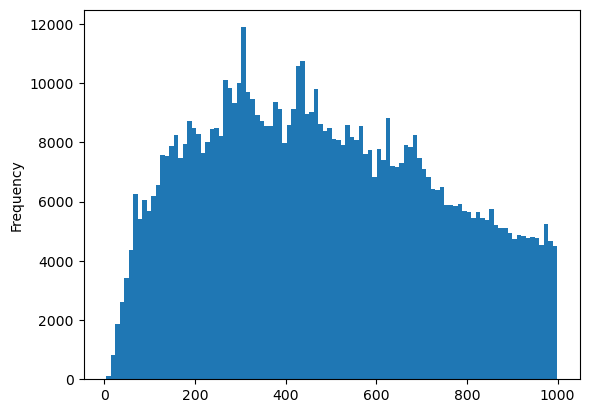

In [7]:
cfpb_df[cfpb_df['narr_len']<1000]['narr_len'].plot(kind='hist', bins=100) 

In [8]:
cfpb_df[(cfpb_df['narr_len']<300)&(cfpb_df['narr_len']>200)].sample(10)[['Consumer complaint narrative','Product']]

,Consumer complaint narrative,Product
16587,"COMENITY BANKXXXX XXXX XXXX a charge off on my consumer reports. A charge off is considered income by the INTERNAL REVENUE SERVICE. A 1099-C was filed, but I have not received my copy. COMENITY BANKXXXX charge off shall be removed from all consumer reporting agencies reports immediately.","Credit reporting, credit repair services, or other personal consumer reports"
877549,"I did not authorize this company to pull my credit. I have asked XXXX XXXX and Equifax to remove this credit pull but they are unresponsive. Equifax also refuses to provide me a copy of their detailed investigation which is illegal. \n\nXXXX XXXX XXXX XXXX XXXX XXXX, PA XXXX","Credit reporting, credit repair services, or other personal consumer reports"
77089,XXXX XXXX XXXX XX/XX/2019 Exeter Fin XX/XX/2019 XXXX XXXX XX/XX/2019 XXXX XXXX XX/XX/2019 XXXX XX/XX/2019 I dont recognize these inquiries and did not authorize none of these companies to run my credit.,"Credit reporting, credit repair services, or other personal consumer reports"
144475,I have submitted multiple disputes and FTC reports regarding these fraudulent items on my credit report that DON'T belong to me. I DO NOT have any idea regarding these fraudulent accounts on my credit report. These accounts are NOT MINE.,"Credit reporting, credit repair services, or other personal consumer reports"
795521,"You have listed incorrect accounts on my credit report that should not be there at all. This is not only unfair to me, but also very troubling, because I have never committed or made any of the things you accuse me of doing. Investigate these accounts or I will take legal action against you.","Credit reporting, credit repair services, or other personal consumer reports"
637550,I am request for to validate this alleged debt to clarify everything. I am not aware of this account with you so please send me validation and send it as a response to this complaint for CFPB to see it aside from sending it to my address.,Debt collection
505501,"To Whom this XXXX concern, I am writing to dispute the following items on my credit report. Each of the accounts and transactions I dispute were opened and made by the thief, not by me. I never authorized, used, or benefited from these accounts or transactions in anyway","Credit reporting, credit repair services, or other personal consumer reports"
921084,On XX/XX/2021 I sent a letter to THE STARK COLLECTION AGENCY. requesting information on an alleged debt they say I owe them and I have not received any correspondence back in regards to that matter. Please help me resolve this issue.,Debt collection
830337,Disputed my balance that hadnt been updated in 2 years. Shellpoint then adds two fraudulent 30 day lates one in XXXX and one in XXXX. They never fixed the balance either. Called to have corrected and they were not helpful. Ive never once been late with this company and I have bank records for proof,"Credit reporting, credit repair services, or other personal consumer reports"
1180743,These a debt on my credit report stating I owe. I have no knowledge of this debt. It also says I made a payment on this in XXXX of 2012 which I did not. The name of the company is accelerated financial.,Debt collection


In [9]:
cfpb_df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'clean_narr', 'dupi_id', 'dupi_len'],
      dtype='object')

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

def plot_proba_distribution(y_pred_proba, classes):
    for idx, _class in enumerate(classes):
        sns.kdeplot(y_pred_proba[:, idx], label=_class)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability distributions of classes')
    plt.legend()
    plt.show()

        
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
def grid_search_svm(df, column_name):
    for unique_value in df[column_name].unique():
        if True:
#         if unique_value in ['Checking or savings account', 
#                             "Money transfer, virtual currency, or money service", 
#                             'Debt collection']:
            try:
                print(f"now training binary classification model for {unique_value}")
                # create target
                df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
                print(df['is_'+ unique_value].value_counts())

                # vectorize
                df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

                # create x and y
                X = list(df['glove_50_features'])
                y = df['is_'+ unique_value]

                # split data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

                # Apply Balancing with ADASYN
                # ada = ADASYN(random_state=42)
                # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
                rus = RandomUnderSampler(random_state=42)
                X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
                print(y_train_resampled.value_counts())

                for data_size in [5000, 10000]:#, 10000, 20000]:
                    # Randomly select x samples for training
                    sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
                    X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
                    y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

                    # grid search
                    # param_grid = {'C': [50, 100, 250], 'gamma': [0.05, 0.15, 0.25, 0.5, 0.75, 0.99], 'kernel': ['rbf']}
                    # param_grid = {'C': [50, 100, 250], 'gamma': [0.05, 0.15, 0.25, 0.35], 'kernel': ['rbf']}
                    param_grid = {'C': [50, 100, 250], 'gamma': [0.05, 0.15, 0.25, 0.35], 'kernel': ['rbf']}

                    # initialize svm and grid
                    svm = SVC(class_weight='balanced')
                    svm.classes_ = np.array([0, 1])
                    grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=4, n_jobs=-1)
                    # fitting the grid
                    grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

                    # evaluate
                    y_pred = grid.predict(np.array(X_test).tolist())
                    print(f1_score(y_test, y_pred, average='weighted'))
                    print(classification_report(y_test, y_pred))
                    print("The best parameters:", grid.best_params_)
                    print("Data size:", data_size)

                    results = grid.cv_results_
                    for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                        print(params, "has a score of", mean_test_score)
                    print("-----------------------------------------------------------------------")
                print("**************************************************************************")
            except:
                pass

In [11]:
# define a dictionary to map the old categories to the new ones
category_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting and repair services",
    "Credit reporting": "Credit reporting and repair services",
    "Credit card or prepaid card": "Credit and prepaid cards",
    "Credit card": "Credit and prepaid cards",
    "Prepaid card": "Credit and prepaid cards",
    "Checking or savings account": "Banking services",
    "Bank account or service": "Banking services",
    "Money transfer, virtual currency, or money service": "Money transfer and virtual currency services",
    "Money transfers": "Money transfer and virtual currency services",
    "Virtual currency": "Money transfer and virtual currency services",
    "Vehicle loan or lease": "Loans and leases",
    "Consumer Loan": "Loans and leases",
    "Payday loan, title loan, or personal loan": "Short-term and personal loans",
    "Payday loan": "Short-term and personal loans",
    "Other financial service": "Other financial service",
    "Mortgage": "Mortgage",
    "Student loan": "Student loan",
    "Debt collection": "Debt collection"
}

# apply the mapping to the 'product' column
cfpb_df['combined_product'] = cfpb_df['Product'].map(category_mapping)
cfpb_df[(cfpb_df['narr_len']>500)].combined_product.value_counts(normalize=True)

Credit reporting and repair services            0.386616
Debt collection                                 0.159558
Mortgage                                        0.125267
Credit and prepaid cards                        0.120523
Banking services                                0.086766
Student loan                                    0.037997
Loans and leases                                0.034030
Money transfer and virtual currency services    0.032370
Short-term and personal loans                   0.016557
Other financial service                         0.000315
Name: combined_product, dtype: float64

In [12]:
cfpb_df[cfpb_df['combined_product'].isna()]['Product']

Series([], Name: Product, dtype: object)

In [13]:
# grid_search_svm(cfpb_df, "combined_product")

In [14]:
def create_svm_dict(df, column_name):
    ml_dict={}
    for unique_value in df[column_name].unique():
        try:
            print(f"now training binary classification model for {unique_value}")
            # create target
            df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)

            value_counts = df['is_'+ unique_value].value_counts()

            if min(value_counts)/max(value_counts) < 0.01:
                print(f"Skipping training binary classification model for {unique_value} due to class imbalance.")
                continue

            # vectorize
            df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

            # create x and y
            X = list(df['glove_50_features'])
            y = df['is_'+ unique_value]

            # split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

            # Apply Balancing with ADASYN
            # ada = ADASYN(random_state=42)
            # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
            rus = RandomUnderSampler(random_state=42)
            X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
            print(y_train_resampled.value_counts())

            # Randomly select x samples for training
            sample_idx = np.random.choice(len(X_train_resampled), 20000, replace=False)
            X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
            y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

            # initialize svm and fit
            svm = SVC(class_weight='balanced', C=50, gamma=0.1, kernel='rbf', probability=True)
            svm.classes_ = np.array([0, 1])
            svm.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

            # evaluate
            y_pred = svm.predict(np.array(X_test).tolist())
            print(f1_score(y_test, y_pred, average='weighted'))
            print(classification_report(y_test, y_pred))

            ml_dict[unique_value] = svm
            print("-----------------------------------------------------------------------")
            
        except:
            pass
    print("**************************************************************************")
    return ml_dict

In [15]:
product_svms = create_svm_dict(cfpb_df.copy(), "combined_product")

now training binary classification model for Credit reporting and repair services
0    431471
1    431471
Name: is_Credit reporting and repair services, dtype: int64
0.8784063733333163
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     60463
           1       0.86      0.86      0.86     47861

    accuracy                           0.88    108324
   macro avg       0.88      0.88      0.88    108324
weighted avg       0.88      0.88      0.88    108324

-----------------------------------------------------------------------
now training binary classification model for Money transfer and virtual currency services
0    28448
1    28448
Name: is_Money transfer and virtual currency services, dtype: int64
0.9221345338442154
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    105214
           1       0.20      0.92      0.32      3110

    accuracy                           0.89    108324

In [16]:
product_svms_long = create_svm_dict(cfpb_df[(cfpb_df['narr_len']>500)].copy(), "combined_product") 

now training binary classification model for Credit reporting and repair services
0    242951
1    242951
Name: is_Credit reporting and repair services, dtype: int64
0.8934752329755518
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     42887
           1       0.85      0.87      0.86     26916

    accuracy                           0.89     69803
   macro avg       0.89      0.89      0.89     69803
weighted avg       0.89      0.89      0.89     69803

-----------------------------------------------------------------------
now training binary classification model for Money transfer and virtual currency services
0    20318
1    20318
Name: is_Money transfer and virtual currency services, dtype: int64
0.9195046840013893
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     67526
           1       0.22      0.93      0.35      2277

    accuracy                           0.89     69803

In [17]:
# Define a dictionary for mapping old values to new ones
issue_dict = {
    "Improper use of your report": "Credit report issues",
    "Incorrect information on your report": "Credit report issues",
    "Problem with a credit reporting company's investigation into an existing problem": "Credit report issues",
    "Credit reporting company's investigation": "Credit report issues",
    "Improper use of my credit report": "Credit report issues",
    "Incorrect information on credit report": "Credit report issues",
    "Unable to get credit report/credit score": "Credit report issues",

    "Fraud or scam": "Fraud and Identity theft issues",
    "Identity theft / Fraud / Embezzlement": "Fraud and Identity theft issues",
    "Received a loan you didn't apply for": "Fraud and Identity theft issues",

    "Managing an account": "Account management issues",
    "Opening an account": "Account management issues",
    "Closing your account": "Account management issues",
    "Closing an account": "Account management issues",
    "Account opening, closing, or management": "Account management issues",
    "Managing, opening, or closing your mobile wallet account": "Account management issues",
    "Managing, opening, or closing account": "Account management issues",

    "Attempts to collect debt not owed": "Unjustified debt collection attempts",
    "Cont'd attempts collect debt not owed": "Unjustified debt collection attempts",

    "Problem with a purchase shown on your statement": "Transaction issues",
    "Problem with a purchase or transfer": "Transaction issues",
    "Other transaction problem": "Transaction issues",
    "Unauthorized transactions or other transaction problem": "Transaction issues",
    "Other transaction issues": "Transaction issues",
    "Transaction issue": "Transaction issues",
    "Unauthorized transactions/trans. issues": "Transaction issues",

    "Struggling to pay your bill": "Payment struggles",
    "Struggling to pay your loan": "Payment struggles",
    "Struggling to repay your loan": "Payment struggles",
    "Can't repay my loan": "Payment struggles",
    "Problems when you are unable to pay": "Payment struggles",

    "Problem with fraud alerts or security freezes": "Fraud alerts and identity protection issues",
    "Identity theft protection or other monitoring services": "Fraud alerts and identity protection issues",
    "Credit monitoring or identity theft protection services": "Fraud alerts and identity protection issues",
    "Credit monitoring or identity protection": "Fraud alerts and identity protection issues",

    "Took or threatened to take negative or legal action": "Improper actions or threats",
    "Threatened to contact someone or share information improperly": "Improper actions or threats",
    "Taking/threatening an illegal action": "Improper actions or threats",
    "Improper contact or sharing of info": "Improper actions or threats",

    "Fees or interest": "Fee and interest issues",
    "Charged fees or interest you didn't expect": "Fee and interest issues",
    "Unexpected or other fees": "Fee and interest issues",
    "Fees": "Fee and interest issues",
    "Cash advance fee": "Fee and interest issues",
    "Overlimit fee": "Fee and interest issues",
    "Balance transfer fee": "Fee and interest issues",

    "Getting a credit card": "Credit and loan acquisition issues",
    "Trouble using your card": "Credit and loan acquisition issues",
    "Trouble using the card": "Credit and loan acquisition issues",
    "Getting a line of credit": "Credit and loan acquisition issues",
    "Shopping for a loan or lease": "Credit and loan acquisition issues",
    "Shopping for a line of credit": "Credit and loan acquisition issues",

    "Problem with customer service": "Customer service issues",
    "Customer service / Customer relations": "Customer service issues",
    "Customer service/Customer relations": "Customer service issues",
    
    "Can't contact lender or servicer": "Communication issues",
    "Can't contact lender": "Communication issues",
    "Communication tactics": "Communication issues",
    
    "Problem with the payoff process at the end of the loan": "Loan issues",
    "Problems at the end of the loan or lease": "Loan issues",
    "Managing the loan or lease": "Loan issues",
    "Loan payment wasn't credited to your account": "Loan issues",
    "Loan servicing, payments, escrow account": "Loan issues",
    "Problem when making payments": "Loan issues",
    "Making/receiving payments, sending money": "Loan issues",
    "Managing the line of credit": "Loan issues",
    "Loan modification,collection,foreclosure": "Loan issues",
    
    "Advertising and marketing, including promotional offers": "Advertising and marketing issues",
    "Advertising": "Advertising and marketing issues",
    "Advertising and marketing": "Advertising and marketing issues",
    "Confusing or misleading advertising or marketing": "Advertising and marketing issues",
    "Advertising, marketing or disclosures": "Advertising and marketing issues",
    
    "Problem with a lender or other company charging your account": "Lender issues",
    "Dealing with your lender or servicer": "Lender issues",
    "Can't stop withdrawals from your bank account": "Lender issues",
    "Money was taken from your bank account on the wrong day or for the wrong amount": "Lender issues",
    "Was approved for a loan, but didn't receive the money": "Lender issues",
    "Applied for loan/did not receive money": "Lender issues",
    "Was approved for a loan, but didn't receive money": "Lender issues",
    
    "Problem with additional add-on products or services": "Product and service issues",
    "Other service problem": "Product and service issues",
    "Other service issues": "Product and service issues",
    
    "Problem with cash advance": "Transaction and payment issues",
    "Charged bank acct wrong day or amt": "Transaction and payment issues",
    "Payment to acct not credited": "Transaction and payment issues",
    "Payoff process": "Transaction and payment issues",
    "Cash advance": "Transaction and payment issues",
    
    "False statements or representation": "False statements and representation issues",
    "Confusing or missing disclosures": "False statements and representation issues",
    "Disclosure verification of debt": "False statements and representation issues",
    "Incorrect/missing disclosures or info": "False statements and representation issues",
    "Disclosures": "False statements and representation issues",
    "Incorrect exchange rate": "False statements and representation issues",
    
    "Applying for a mortgage or refinancing an existing mortgage": "Mortgage issues",
    "Struggling to pay mortgage": "Mortgage issues",
    "Closing on a mortgage": "Mortgage issues",
    "Application, originator, mortgage broker": "Mortgage issues",
    
    "Credit limit changed": "Credit issues",
    "Credit decision / Underwriting": "Credit issues",
    "Credit card protection / Debt protection": "Credit issues",
    "Rewards": "Credit issues",
    "Credit determination": "Credit issues",
    "Credit line increase/decrease": "Credit issues",
    "APR or interest rate": "Credit issues",
    
    "Vehicle was repossessed or sold the vehicle": "Vehicle issues",
    "Vehicle was damaged or destroyed the vehicle": "Vehicle issues",
    "Lender repossessed or sold the vehicle": "Vehicle issues",
    "Lender damaged or destroyed vehicle": "Vehicle issues",
    "Property was sold": "Vehicle issues",
    "Property was damaged or destroyed property": "Vehicle issues",
    "Lender sold the property": "Vehicle issues",
    "Lender damaged or destroyed property": "Vehicle issues",
    
    "Bankruptcy": "Bankruptcy issues",
    "Balance transfer": "Balance transfer issues",
    "Using a debit or ATM card": "Debit and ATM card issues",
    
    "Privacy": "Privacy issues",
    
    "Forbearance / Workout plans": "Workout plan issues",
    "Sale of account": "Account sale issues",
    
    "Adding money": "Money adding issues",
    "Problem adding money": "Money adding issues",
    
    "Delinquent account": "Account delinquency issues",
    
    "Application processing delay": "Application processing issues",
    
    "Arbitration": "Arbitration issues",
    
    "Convenience checks": "Check issues",
    "Lost or stolen check": "Check issues",
    
    "Overdraft, savings, or rewards features": "Overdraft, savings, or rewards issues",
    "Overdraft, savings or rewards features": "Overdraft, savings, or rewards issues",
    
    "Unexpected/Other fees": "Unexpected fees issues",
    "Balance transfer fee": "Unexpected fees issues",
    "Excessive fees": "Unexpected fees issues",
    
    "Other": "Other issues"
}

cfpb_df['combined_issue'] = cfpb_df['Issue'].map(issue_dict).fillna(cfpb_df['Issue'])

In [18]:
combined_issue_svms = create_svm_dict(cfpb_df.copy(), "combined_issue")

now training binary classification model for Credit report issues
0    422611
1    422611
Name: is_Credit report issues, dtype: int64
0.8705425145648628
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     61478
           1       0.85      0.85      0.85     46846

    accuracy                           0.87    108324
   macro avg       0.87      0.87      0.87    108324
weighted avg       0.87      0.87      0.87    108324

-----------------------------------------------------------------------
now training binary classification model for Fraud and Identity theft issues
0    12878
1    12878
Name: is_Fraud and Identity theft issues, dtype: int64
0.9012924016322603
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    106852
           1       0.07      0.85      0.13      1472

    accuracy                           0.84    108324
   macro avg       0.53      0.84      0.52    108324
wei

0.8465288243166058
              precision    recall  f1-score   support

           0       0.99      0.77      0.87    105454
           1       0.08      0.78      0.15      2870

    accuracy                           0.77    108324
   macro avg       0.54      0.77      0.51    108324
weighted avg       0.97      0.77      0.85    108324

-----------------------------------------------------------------------
now training binary classification model for Fee and interest issues
0    15021
1    15021
Name: is_Fee and interest issues, dtype: int64
0.897615694079767
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    106668
           1       0.08      0.86      0.14      1656

    accuracy                           0.84    108324
   macro avg       0.54      0.85      0.52    108324
weighted avg       0.98      0.84      0.90    108324

-----------------------------------------------------------------------
now training binary classif

Skipping training binary classification model for Charged fees or interest I didn't expect due to class imbalance.
now training binary classification model for Application processing issues
Skipping training binary classification model for Application processing issues due to class imbalance.
now training binary classification model for Transaction and payment issues
Skipping training binary classification model for Transaction and payment issues due to class imbalance.
now training binary classification model for Arbitration issues
Skipping training binary classification model for Arbitration issues due to class imbalance.
now training binary classification model for Privacy issues
Skipping training binary classification model for Privacy issues due to class imbalance.
now training binary classification model for Workout plan issues
Skipping training binary classification model for Workout plan issues due to class imbalance.
now training binary classification model for Account sale is

In [19]:
combined_issue_svms_long = create_svm_dict(cfpb_df[(cfpb_df['narr_len']>500)].copy(), "combined_issue")

now training binary classification model for Credit report issues
0    237312
1    237312
Name: is_Credit report issues, dtype: int64
0.885571502234733
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     43471
           1       0.83      0.87      0.85     26332

    accuracy                           0.89     69803
   macro avg       0.88      0.88      0.88     69803
weighted avg       0.89      0.89      0.89     69803

-----------------------------------------------------------------------
now training binary classification model for Fraud and Identity theft issues
0    9393
1    9393
Name: is_Fraud and Identity theft issues, dtype: int64
now training binary classification model for Account management issues
0    46401
1    46401
Name: is_Account management issues, dtype: int64
0.8904946321430205
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     64546
           1       0.35    

0    9751
1    9751
Name: is_Credit and loan acquisition issues, dtype: int64
now training binary classification model for Problem caused by your funds being low
Skipping training binary classification model for Problem caused by your funds being low due to class imbalance.
now training binary classification model for Check issues
Skipping training binary classification model for Check issues due to class imbalance.
now training binary classification model for Vehicle issues
Skipping training binary classification model for Vehicle issues due to class imbalance.
now training binary classification model for Advertising and marketing issues
Skipping training binary classification model for Advertising and marketing issues due to class imbalance.
now training binary classification model for Getting a loan or lease
Skipping training binary classification model for Getting a loan or lease due to class imbalance.
now training binary classification model for Money was not available when promi

In [20]:
issue_svms = create_svm_dict(cfpb_df.copy(), "Issue")

now training binary classification model for Improper use of your report
0    83290
1    83290
Name: is_Improper use of your report, dtype: int64
0.9111025270160367
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     99152
           1       0.44      0.85      0.58      9172

    accuracy                           0.90    108324
   macro avg       0.71      0.87      0.76    108324
weighted avg       0.94      0.90      0.91    108324

-----------------------------------------------------------------------
now training binary classification model for Incorrect information on your report
0    188288
1    188288
Name: is_Incorrect information on your report, dtype: int64
0.7761678185238889
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     87332
           1       0.43      0.81      0.56     20992

    accuracy                           0.75    108324
   macro avg       0.68      0.78

Skipping training binary classification model for Problem with fraud alerts or security freezes due to class imbalance.
now training binary classification model for Problems at the end of the loan or lease
Skipping training binary classification model for Problems at the end of the loan or lease due to class imbalance.
now training binary classification model for Applying for a mortgage or refinancing an existing mortgage
Skipping training binary classification model for Applying for a mortgage or refinancing an existing mortgage due to class imbalance.
now training binary classification model for Problem with a lender or other company charging your account
Skipping training binary classification model for Problem with a lender or other company charging your account due to class imbalance.
now training binary classification model for False statements or representation
0    17693
1    17693
Name: is_False statements or representation, dtype: int64
0.844239638138026
              precisi

0    14593
1    14593
Name: is_Dealing with your lender or servicer, dtype: int64
0.9362598936801241
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    106683
           1       0.13      0.92      0.22      1641

    accuracy                           0.90    108324
   macro avg       0.56      0.91      0.58    108324
weighted avg       0.99      0.90      0.94    108324

-----------------------------------------------------------------------
now training binary classification model for Getting the loan
Skipping training binary classification model for Getting the loan due to class imbalance.
now training binary classification model for Can't stop withdrawals from your bank account
Skipping training binary classification model for Can't stop withdrawals from your bank account due to class imbalance.
now training binary classification model for Problem with a company's investigation into an existing issue
Skipping training binary clas

Skipping training binary classification model for Shopping for a loan or lease due to class imbalance.
now training binary classification model for Making/receiving payments, sending money
Skipping training binary classification model for Making/receiving payments, sending money due to class imbalance.
now training binary classification model for Improper use of my credit report
Skipping training binary classification model for Improper use of my credit report due to class imbalance.
now training binary classification model for Can't repay my loan
Skipping training binary classification model for Can't repay my loan due to class imbalance.
now training binary classification model for Billing disputes
Skipping training binary classification model for Billing disputes due to class imbalance.
now training binary classification model for Other fee
Skipping training binary classification model for Other fee due to class imbalance.
now training binary classification model for Late fee


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Late fee due to class imbalance.
now training binary classification model for Billing statement
Skipping training binary classification model for Billing statement due to class imbalance.
now training binary classification model for Unsolicited issuance of credit card


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Unsolicited issuance of credit card due to class imbalance.
now training binary classification model for Other transaction issues
Skipping training binary classification model for Other transaction issues due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Closing/Cancelling account
Skipping training binary classification model for Closing/Cancelling account due to class imbalance.
now training binary classification model for Can't contact lender
Skipping training binary classification model for Can't contact lender due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Taking out the loan or lease
Skipping training binary classification model for Taking out the loan or lease due to class imbalance.
now training binary classification model for Problems caused by my funds being low
Skipping training binary classification model for Problems caused by my funds being low due to class imbalance.
now training binary classification model for Deposits and withdrawals


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Deposits and withdrawals due to class imbalance.
now training binary classification model for APR or interest rate
Skipping training binary classification model for APR or interest rate due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Other
Skipping training binary classification model for Other due to class imbalance.
now training binary classification model for Problems when you are unable to pay


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Problems when you are unable to pay due to class imbalance.
now training binary classification model for Can't stop charges to bank account
Skipping training binary classification model for Can't stop charges to bank account due to class imbalance.
now training binary classification model for Bankruptcy
Skipping training binary classification model for Bankruptcy due to class imbalance.
now training binary classification model for Balance transfer


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Balance transfer due to class imbalance.
now training binary classification model for Advertising and marketing
Skipping training binary classification model for Advertising and marketing due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Vehicle was damaged or destroyed the vehicle
Skipping training binary classification model for Vehicle was damaged or destroyed the vehicle due to class imbalance.
now training binary classification model for Customer service / Customer relations
Skipping training binary classification model for Customer service / Customer relations due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Transaction issue
Skipping training binary classification model for Transaction issue due to class imbalance.
now training binary classification model for Received a loan I didn't apply for
Skipping training binary classification model for Received a loan I didn't apply for due to class imbalance.
now training binary classification model for Managing, opening, or closing account
Skipping training binary classification model for Managing, opening, or closing account due to class imbalance.
now training binary classification model for Account terms and changes


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

Skipping training binary classification model for Account terms and changes due to class imbalance.
now training binary classification model for Credit monitoring or identity protection
Skipping training binary classification model for Credit monitoring or identity protection due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Charged fees or interest I didn't expect
Skipping training binary classification model for Charged fees or interest I didn't expect due to class imbalance.
now training binary classification model for Application processing delay
Skipping training binary classification model for Application processing delay due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Problem with cash advance
Skipping training binary classification model for Problem with cash advance due to class imbalance.
now training binary classification model for Arbitration


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Arbitration due to class imbalance.
now training binary classification model for Credit determination
Skipping training binary classification model for Credit determination due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Advertising, marketing or disclosures
Skipping training binary classification model for Advertising, marketing or disclosures due to class imbalance.
now training binary classification model for Credit line increase/decrease
Skipping training binary classification model for Credit line increase/decrease due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Charged bank acct wrong day or amt
Skipping training binary classification model for Charged bank acct wrong day or amt due to class imbalance.
now training binary classification model for Other service issues
Skipping training binary classification model for Other service issues due to class imbalance.
now training binary classification model for Privacy


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Privacy due to class imbalance.
now training binary classification model for Unauthorized transactions/trans. issues
Skipping training binary classification model for Unauthorized transactions/trans. issues due to class imbalance.
now training binary classification model for Fees


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Fees due to class imbalance.
now training binary classification model for Incorrect/missing disclosures or info
Skipping training binary classification model for Incorrect/missing disclosures or info due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Payment to acct not credited
Skipping training binary classification model for Payment to acct not credited due to class imbalance.
now training binary classification model for Payoff process
Skipping training binary classification model for Payoff process due to class imbalance.
now training binary classification model for Cash advance fee


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Cash advance fee due to class imbalance.
now training binary classification model for Convenience checks


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Convenience checks due to class imbalance.
now training binary classification model for Forbearance / Workout plans
Skipping training binary classification model for Forbearance / Workout plans due to class imbalance.
now training binary classification model for Customer service/Customer relations


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Customer service/Customer relations due to class imbalance.
now training binary classification model for Sale of account
Skipping training binary classification model for Sale of account due to class imbalance.
now training binary classification model for Applied for loan/did not receive money


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Applied for loan/did not receive money due to class imbalance.
now training binary classification model for Adding money


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Adding money due to class imbalance.
now training binary classification model for Lender repossessed or sold the vehicle
Skipping training binary classification model for Lender repossessed or sold the vehicle due to class imbalance.
now training binary classification model for Was approved for a loan, but didn't receive money


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Was approved for a loan, but didn't receive money due to class imbalance.
now training binary classification model for Cash advance
Skipping training binary classification model for Cash advance due to class imbalance.
now training binary classification model for Problem with overdraft


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Problem with overdraft due to class imbalance.
now training binary classification model for Managing the line of credit
Skipping training binary classification model for Managing the line of credit due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Disclosures
Skipping training binary classification model for Disclosures due to class imbalance.
now training binary classification model for Incorrect exchange rate
Skipping training binary classification model for Incorrect exchange rate due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Overdraft, savings or rewards features
Skipping training binary classification model for Overdraft, savings or rewards features due to class imbalance.
now training binary classification model for Unexpected/Other fees
Skipping training binary classification model for Unexpected/Other fees due to class imbalance.
now training binary classification model for Balance transfer fee


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Balance transfer fee due to class imbalance.
now training binary classification model for Overlimit fee
Skipping training binary classification model for Overlimit fee due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Lender damaged or destroyed vehicle
Skipping training binary classification model for Lender damaged or destroyed vehicle due to class imbalance.
now training binary classification model for Problem with an overdraft
Skipping training binary classification model for Problem with an overdraft due to class imbalance.
now training binary classification model for Property was sold


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Property was sold due to class imbalance.
now training binary classification model for Property was damaged or destroyed property


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Property was damaged or destroyed property due to class imbalance.
now training binary classification model for Shopping for a line of credit
Skipping training binary classification model for Shopping for a line of credit due to class imbalance.

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)



now training binary classification model for Lender sold the property
Skipping training binary classification model for Lender sold the property due to class imbalance.
now training binary classification model for Lender damaged or destroyed property
Skipping training binary classification model for Lender damaged or destroyed property due to class imbalance.
**************************************************************************


In [21]:
issue_svms_long = create_svm_dict(cfpb_df[(cfpb_df['narr_len']>500)].copy(), "Issue")

now training binary classification model for Incorrect information on your report
0    106609
1    106609
Name: is_Incorrect information on your report, dtype: int64
0.79857776748396
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     57896
           1       0.42      0.83      0.55     11907

    accuracy                           0.77     69803
   macro avg       0.69      0.79      0.70     69803
weighted avg       0.86      0.77      0.80     69803

-----------------------------------------------------------------------
now training binary classification model for Fraud or scam
0    8116
1    8116
Name: is_Fraud or scam, dtype: int64
now training binary classification model for Managing an account
0    25232
1    25232
Name: is_Managing an account, dtype: int64
0.8995655823308447
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     66952
           1       0.22      0.93      0.36 

0.9256215948299512
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     68308
           1       0.15      0.94      0.27      1495

    accuracy                           0.89     69803
   macro avg       0.58      0.91      0.60     69803
weighted avg       0.98      0.89      0.93     69803

-----------------------------------------------------------------------
now training binary classification model for Opening an account
Skipping training binary classification model for Opening an account due to class imbalance.
now training binary classification model for Trouble using your card
Skipping training binary classification model for Trouble using your card due to class imbalance.
now training binary classification model for Struggling to pay your bill
Skipping training binary classification model for Struggling to pay your bill due to class imbalance.
now training binary classification model for Managing the loan or lease
0    8375
1

Skipping training binary classification model for Wrong amount charged or received due to class imbalance.
now training binary classification model for Was approved for a loan, but didn't receive the money
Skipping training binary classification model for Was approved for a loan, but didn't receive the money due to class imbalance.
now training binary classification model for Received a loan you didn't apply for
Skipping training binary classification model for Received a loan you didn't apply for due to class imbalance.
now training binary classification model for Advertising
Skipping training binary classification model for Advertising due to class imbalance.
now training binary classification model for Can't stop withdrawals from your bank account
Skipping training binary classification model for Can't stop withdrawals from your bank account due to class imbalance.
now training binary classification model for Delinquent account
Skipping training binary classification model for Delin

C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Deposits and withdrawals due to class imbalance.
now training binary classification model for Billing statement
Skipping training binary classification model for Billing statement due to class imbalance.
now training binary classification model for Other


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Other due to class imbalance.
now training binary classification model for Problems when you are unable to pay
Skipping training binary classification model for Problems when you are unable to pay due to class imbalance.
now training binary classification model for Balance transfer


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Balance transfer due to class imbalance.
now training binary classification model for Vehicle was damaged or destroyed the vehicle
Skipping training binary classification model for Vehicle was damaged or destroyed the vehicle due to class imbalance.
now training binary classification model for Transaction issue


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Transaction issue due to class imbalance.
now training binary classification model for Received a loan I didn't apply for
Skipping training binary classification model for Received a loan I didn't apply for due to class imbalance.
now training binary classification model for Improper contact or sharing of info


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Improper contact or sharing of info due to class imbalance.
now training binary classification model for Managing, opening, or closing account
Skipping training binary classification model for Managing, opening, or closing account due to class imbalance.
now training binary classification model for Other fee


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Other fee due to class imbalance.
now training binary classification model for Customer service / Customer relations
Skipping training binary classification model for Customer service / Customer relations due to class imbalance.
now training binary classification model for Account terms and changes


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Account terms and changes due to class imbalance.
now training binary classification model for Can't contact lender
Skipping training binary classification model for Can't contact lender due to class imbalance.
now training binary classification model for Advertising and marketing


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Advertising and marketing due to class imbalance.
now training binary classification model for Unable to get credit report/credit score
Skipping training binary classification model for Unable to get credit report/credit score due to class imbalance.
now training binary classification model for Credit monitoring or identity protection


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Credit monitoring or identity protection due to class imbalance.
now training binary classification model for Unsolicited issuance of credit card
Skipping training binary classification model for Unsolicited issuance of credit card due to class imbalance.
now training binary classification model for Application processing delay


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Application processing delay due to class imbalance.
now training binary classification model for Problem with cash advance
Skipping training binary classification model for Problem with cash advance due to class imbalance.
now training binary classification model for Advertising, marketing or disclosures


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Advertising, marketing or disclosures due to class imbalance.
now training binary classification model for Charged bank acct wrong day or amt
Skipping training binary classification model for Charged bank acct wrong day or amt due to class imbalance.
now training binary classification model for Can't stop charges to bank account


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Can't stop charges to bank account due to class imbalance.
now training binary classification model for Other service issues
Skipping training binary classification model for Other service issues due to class imbalance.
now training binary classification model for Privacy


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Privacy due to class imbalance.
now training binary classification model for Unauthorized transactions/trans. issues
Skipping training binary classification model for Unauthorized transactions/trans. issues due to class imbalance.
now training binary classification model for Fees


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Fees due to class imbalance.
now training binary classification model for Incorrect/missing disclosures or info
Skipping training binary classification model for Incorrect/missing disclosures or info due to class imbalance.
now training binary classification model for Payment to acct not credited


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Payment to acct not credited due to class imbalance.
now training binary classification model for Charged fees or interest I didn't expect
Skipping training binary classification model for Charged fees or interest I didn't expect due to class imbalance.
now training binary classification model for Payoff process


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Payoff process due to class imbalance.
now training binary classification model for Credit determination
Skipping training binary classification model for Credit determination due to class imbalance.
now training binary classification model for Cash advance fee


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Cash advance fee due to class imbalance.
now training binary classification model for Credit line increase/decrease
Skipping training binary classification model for Credit line increase/decrease due to class imbalance.
now training binary classification model for Convenience checks


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Convenience checks due to class imbalance.
now training binary classification model for Forbearance / Workout plans
Skipping training binary classification model for Forbearance / Workout plans due to class imbalance.
now training binary classification model for Excessive fees


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Excessive fees due to class imbalance.
now training binary classification model for Customer service/Customer relations
Skipping training binary classification model for Customer service/Customer relations due to class imbalance.
now training binary classification model for Sale of account


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Sale of account due to class imbalance.
now training binary classification model for Adding money
Skipping training binary classification model for Adding money due to class imbalance.
now training binary classification model for Applied for loan/did not receive money


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Applied for loan/did not receive money due to class imbalance.
now training binary classification model for Lender repossessed or sold the vehicle
Skipping training binary classification model for Lender repossessed or sold the vehicle due to class imbalance.
now training binary classification model for Was approved for a loan, but didn't receive money


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Was approved for a loan, but didn't receive money due to class imbalance.
now training binary classification model for Cash advance
Skipping training binary classification model for Cash advance due to class imbalance.
now training binary classification model for Problem with overdraft


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Problem with overdraft due to class imbalance.
now training binary classification model for Lost or stolen money order
Skipping training binary classification model for Lost or stolen money order due to class imbalance.
now training binary classification model for Managing the line of credit


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Managing the line of credit due to class imbalance.
now training binary classification model for Incorrect exchange rate
Skipping training binary classification model for Incorrect exchange rate due to class imbalance.
now training binary classification model for Arbitration


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Arbitration due to class imbalance.
now training binary classification model for Overdraft, savings or rewards features
Skipping training binary classification model for Overdraft, savings or rewards features due to class imbalance.
now training binary classification model for Unexpected/Other fees


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Unexpected/Other fees due to class imbalance.
now training binary classification model for Balance transfer fee
Skipping training binary classification model for Balance transfer fee due to class imbalance.
now training binary classification model for Bankruptcy


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Bankruptcy due to class imbalance.
now training binary classification model for Overlimit fee
Skipping training binary classification model for Overlimit fee due to class imbalance.
now training binary classification model for Lender damaged or destroyed vehicle


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Lender damaged or destroyed vehicle due to class imbalance.
now training binary classification model for Problem with an overdraft
Skipping training binary classification model for Problem with an overdraft due to class imbalance.
now training binary classification model for Disclosures


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Disclosures due to class imbalance.
now training binary classification model for Property was sold
Skipping training binary classification model for Property was sold due to class imbalance.
now training binary classification model for Property was damaged or destroyed property


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Property was damaged or destroyed property due to class imbalance.
now training binary classification model for Shopping for a line of credit
Skipping training binary classification model for Shopping for a line of credit due to class imbalance.
now training binary classification model for Lender sold the property


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


Skipping training binary classification model for Lender sold the property due to class imbalance.
now training binary classification model for Lender damaged or destroyed property
Skipping training binary classification model for Lender damaged or destroyed property due to class imbalance.
**************************************************************************


C:\Users\JYM\AppData\Local\Temp/ipykernel_62316/618260996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)


In [22]:
# ?issue_svms_long

In [23]:
import pickle
# Save each model
with open("_product_svm_models_dict.pkl", 'wb') as file:
    pickle.dump(product_svms, file)
with open("_product_svm_long_models_dict.pkl", 'wb') as file:
    pickle.dump(product_svms_long, file)
    
with open("_combined_issue_svm_models_dict.pkl", 'wb') as file:
    pickle.dump(combined_issue_svms, file)
with open("_combined_issue_svm_long_models_dict.pkl", 'wb') as file:
    pickle.dump(combined_issue_svms_long, file)
    
with open("_issue_svm_models_dict.pkl", 'wb') as file:
    pickle.dump(issue_svms, file)
with open("_issue_svm_long_models_dict.pkl", 'wb') as file:
    pickle.dump(issue_svms_long, file)

In [28]:
def vectorize_text(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

with open("_combined_issue_svm_models_dict.pkl", 'rb') as file:
    loaded_model_dict = pickle.load(file)

    
text = """I've had a loan out with Money Lion since XX/XX/XXXX I paid off the full balance on or before XX/XX/XXXX. 
\n\nThat loan has been paid in full and closed and a new loan has been initiated. 
\nThey haven't reported old loan as closed and haven't reported the new loan as open They are two separate loans"""
for key, model in loaded_model_dict.items():
    print(key, model.predict([vectorize_text(text)]))
    print(key, model.predict_proba([vectorize_text(text)])[0][1])
    

Credit report issues [1]
Credit report issues 0.9029135912428293
Fraud and Identity theft issues [0]
Fraud and Identity theft issues 0.022057915823955117
Account management issues [0]
Account management issues 0.0012739969339867604
Improper actions or threats [0]
Improper actions or threats 0.038605907285236316
Unjustified debt collection attempts [0]
Unjustified debt collection attempts 0.2835213974103205
Transaction issues [0]
Transaction issues 0.00015346309669323526
Trouble during payment process [0]
Trouble during payment process 0.04868535563793529
Payment struggles [1]
Payment struggles 0.6915370817171704
Other features, terms, or problems [0]
Other features, terms, or problems 7.356868946666671e-05
Loan issues [1]
Loan issues 0.7747831003558409
Written notification about debt [0]
Written notification about debt 0.0038027520225490676
Fraud alerts and identity protection issues [0]
Fraud alerts and identity protection issues 0.09250284750999849
Mortgage issues [0]
Mortgage issues

In [16]:
import pandas as pd

# Assuming df is your DataFrame

# Compute counts for each combination of product and issues
df_counts = cfpb_df.groupby(['combined_product', 'Issue']).size().reset_index(name='counts')

import altair as alt

# Create a heatmap
heatmap = alt.Chart(df_counts).mark_rect().encode(
    x='combined_product:N',
    y='Issue:N',
    color='counts:Q'
)

# Display the chart
heatmap


alt.Chart(...)

In [19]:
df_counts

,combined_product,Issue,counts
0,Banking services,"Account opening, closing, or management",6313
1,Banking services,Closing an account,9506
2,Banking services,Credit monitoring or identity theft protection services,32
3,Banking services,Deposits and withdrawals,3415
4,Banking services,Getting a line of credit,1
...,...,...,...
229,Student loan,Incorrect information on your report,1024
230,Student loan,Problem with a credit reporting company's investigation into an existing problem,550
231,Student loan,Problem with fraud alerts or security freezes,17
232,Student loan,Struggling to repay your loan,4936


In [20]:
cfpb_df[(cfpb_df['narr_len']>500)].Issue.value_counts(normalize=True)

Incorrect information on your report                                                0.169788
Problem with a credit reporting company's investigation into an existing problem    0.124937
Improper use of your report                                                         0.063097
Attempts to collect debt not owed                                                   0.058989
Trouble during payment process                                                      0.041716
                                                                                      ...   
Shopping for a line of credit                                                       0.000006
Problem with an overdraft                                                           0.000004
Lender sold the property                                                            0.000004
Lender damaged or destroyed vehicle                                                 0.000003
Lender damaged or destroyed property                                  

In [27]:
issues = cfpb_df[(cfpb_df['narr_len']>500)].Issue.value_counts()
issues[issues>5000]

Incorrect information on your report                                                118516
Problem with a credit reporting company's investigation into an existing problem     87209
Improper use of your report                                                          44043
Attempts to collect debt not owed                                                    41176
Trouble during payment process                                                       29119
Managing an account                                                                  28083
Problem with a purchase shown on your statement                                      19338
Written notification about debt                                                      16765
Struggling to pay mortgage                                                           14648
False statements or representation                                                   13365
Dealing with your lender or servicer                                                 13183

In [17]:
for x in cfpb_df.Issue.unique():
    print(x)

Improper use of your report
Incorrect information on your report
Fraud or scam
Managing an account
Problem with a credit reporting company's investigation into an existing problem
Threatened to contact someone or share information improperly
Unable to get your credit report or credit score
Attempts to collect debt not owed
Other transaction problem
Trouble during payment process
Problem with a purchase shown on your statement
Struggling to pay your bill
Other features, terms, or problems
Managing the loan or lease
Closing your account
Took or threatened to take negative or legal action
Struggling to pay your loan
Written notification about debt
Problem with fraud alerts or security freezes
Problems at the end of the loan or lease
Applying for a mortgage or refinancing an existing mortgage
Problem with a lender or other company charging your account
False statements or representation
Closing an account
Opening an account
Fees or interest
Getting a credit card
Communication tactics
Strug

In [13]:
def train_svm(df, column_name):
    model_dict = {}
    for unique_value in df[column_name].unique():
        # create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        
        
        value_counts = df['is_'+ unique_value].value_counts()
        # check if the minority class is at least 1% of the majority class
        if min(value_counts)/max(value_counts) < 0.05:
            print(f"Skipping training binary classification model for {unique_value} due to class imbalance.")
            continue
        print(value_counts)
        print(f"now training binary classification model for {unique_value}")

        # create features
        df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

        X = list(df['glove_50_features'])
        y = df['is_'+ unique_value]

        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        # Apply ADASYN
        ada = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)

        # Randomly select 15000 samples for training
        # Randomly select 15000 samples for training
        sample_idx = np.random.choice(len(X_train_resampled), 30000, replace=False)
        X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
        y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]



        # initialize svm
        svm = SVC(class_weight='balanced', C=350, gamma=0.75, kernel = 'rbf', probability=True)
        svm.classes_ = np.array([0, 1])

        # fitting the model
        svm.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)


        # evaluate
        y_pred = svm.predict(np.array(X_test).tolist())
        print(classification_report(y_test, y_pred))
        print(svm.classes_)
        
        # Get the probabilities
        y_pred_proba = svm.predict_proba(np.array(X_test).tolist())

        # Plot the distribution
        plot_proba_distribution(y_pred_proba, svm.classes_)

        model_dict[f"{unique_value}_clf"] = svm
        print("**************************************************************************")
    return model_dict

0    632832
1    450408
Name: is_Credit reporting, credit repair services, or other personal consumer reports, dtype: int64
now training binary classification model for Credit reporting, credit repair services, or other personal consumer reports
              precision    recall  f1-score   support

           0       0.87      0.82      0.84     63297
           1       0.76      0.82      0.79     45027

    accuracy                           0.82    108324
   macro avg       0.81      0.82      0.82    108324
weighted avg       0.82      0.82      0.82    108324

[0 1]


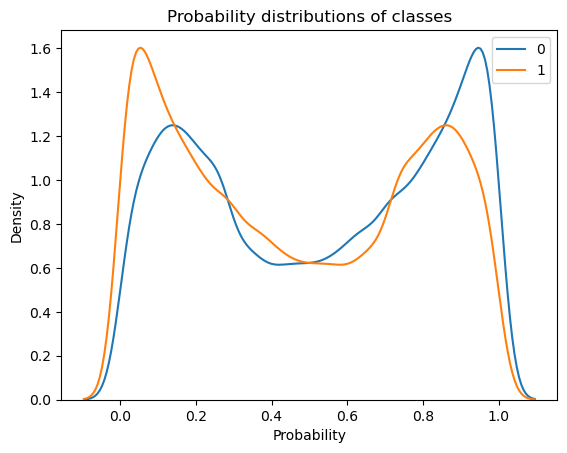

**************************************************************************
Skipping training binary classification model for Money transfer, virtual currency, or money service due to class imbalance.
0    1016747
1      66493
Name: is_Checking or savings account, dtype: int64
now training binary classification model for Checking or savings account


In [ ]:
# grid_search_svm(cfpb_df, "Product")
product_models = train_svm(cfpb_df, "Product")

In [ ]:
cfpb_df_long = cfpb_df[cfpb_df['narr_len']>275].copy()
long_product_models = train_svm(cfpb_df_long, "Product") # Did'nt see huge improvements

In [ ]:
issue_models = train_svm(cfpb_df, "Issue")

In [ ]:
long_issue_models = train_svm(cfpb_df_long, "Issue") # see improvements

In [70]:
import pickle
# Save each model
for model_name, model in product_models.items():
    filename = f"Product {model_name}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [71]:
# for model_name, model in long_product_models.items():
#     filename = f"Product {model_name} long.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [72]:
# for model_name, model in issue_models.items():
#     filename = f"Issue {model_name}.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [73]:
for model_name, model in long_issue_models.items():
    filename = f"Issue {model_name} long.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [74]:
vectorized_text = vectorize_text("i called the collection agency for my debt verification. but they cant verify it. and it wasnt on their system. and said that they will remove it on my credit report. its been 2 months i believe but its still shows on my credit as open and with negative information.")

x = product_models['Credit reporting, credit repair services, or other personal consumer reports_clf'].predict_proba([vectorized_text])
print(x)

[[0.65038987 0.34961013]]
